<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[22:10:25] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


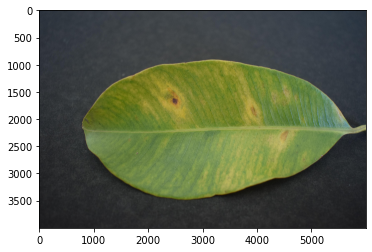

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

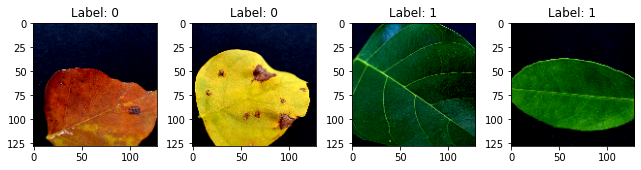

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[22:10:33] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[22:10:35] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2598001571332103 samples/sec                   batch loss = 0.8633334636688232 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2652715449545713 samples/sec                   batch loss = 1.2985420227050781 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2689453284247203 samples/sec                   batch loss = 1.1618993282318115 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2597810485625562 samples/sec                   batch loss = 1.1413053274154663 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.264001897372233 samples/sec                   batch loss = 0.3503694534301758 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.26475075639444 samples/sec                   batch loss = 0.8502174019813538 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2596665038889459 samples/sec                   batch loss = 0.4277735650539398 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.264866895149486 samples/sec                   batch loss = 0.6808005571365356 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.268673100869518 samples/sec                   batch loss = 0.6174076795578003 | accuracy = 0.5888888888888889


Epoch[1] Batch[50] Speed: 1.264550471925939 samples/sec                   batch loss = 0.4205326437950134 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.2661165918605681 samples/sec                   batch loss = 0.5335233211517334 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.266489439439379 samples/sec                   batch loss = 0.44273725152015686 | accuracy = 0.6083333333333333


Epoch[1] Batch[65] Speed: 1.2673989187399028 samples/sec                   batch loss = 0.6282676458358765 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.2664547355640776 samples/sec                   batch loss = 0.5795450210571289 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2678605678146664 samples/sec                   batch loss = 0.40770626068115234 | accuracy = 0.6166666666666667


Epoch[1] Batch[80] Speed: 1.2659639224923436 samples/sec                   batch loss = 0.297516405582428 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.2669682219130045 samples/sec                   batch loss = 0.7563520073890686 | accuracy = 0.6264705882352941


Epoch[1] Batch[90] Speed: 1.2634631231213411 samples/sec                   batch loss = 0.8637545108795166 | accuracy = 0.625


Epoch[1] Batch[95] Speed: 1.267131373706951 samples/sec                   batch loss = 0.5053550601005554 | accuracy = 0.6289473684210526


Epoch[1] Batch[100] Speed: 1.2719742724396284 samples/sec                   batch loss = 0.8240180611610413 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.265170882968864 samples/sec                   batch loss = 0.7840032577514648 | accuracy = 0.6261904761904762


Epoch[1] Batch[110] Speed: 1.2647908018317633 samples/sec                   batch loss = 0.7853046655654907 | accuracy = 0.6295454545454545


Epoch[1] Batch[115] Speed: 1.2689324676739135 samples/sec                   batch loss = 0.22919857501983643 | accuracy = 0.6326086956521739


Epoch[1] Batch[120] Speed: 1.2707592865085608 samples/sec                   batch loss = 0.9479056596755981 | accuracy = 0.63125


Epoch[1] Batch[125] Speed: 1.2651896783509504 samples/sec                   batch loss = 0.5877485275268555 | accuracy = 0.636


Epoch[1] Batch[130] Speed: 1.2635077496830351 samples/sec                   batch loss = 0.6165888905525208 | accuracy = 0.6326923076923077


Epoch[1] Batch[135] Speed: 1.2660049045833812 samples/sec                   batch loss = 1.826709270477295 | accuracy = 0.6351851851851852


Epoch[1] Batch[140] Speed: 1.2652598081825366 samples/sec                   batch loss = 0.3089621663093567 | accuracy = 0.6410714285714286


Epoch[1] Batch[145] Speed: 1.2671320436249736 samples/sec                   batch loss = 0.27198076248168945 | accuracy = 0.6431034482758621


Epoch[1] Batch[150] Speed: 1.2650522082745128 samples/sec                   batch loss = 0.5566898584365845 | accuracy = 0.6433333333333333


Epoch[1] Batch[155] Speed: 1.26396542518588 samples/sec                   batch loss = 0.87254798412323 | accuracy = 0.6435483870967742


Epoch[1] Batch[160] Speed: 1.2675174595883436 samples/sec                   batch loss = 0.6853736639022827 | accuracy = 0.6484375


Epoch[1] Batch[165] Speed: 1.2630584879569446 samples/sec                   batch loss = 0.44109585881233215 | accuracy = 0.6515151515151515


Epoch[1] Batch[170] Speed: 1.2701537693752358 samples/sec                   batch loss = 0.42670464515686035 | accuracy = 0.6529411764705882


Epoch[1] Batch[175] Speed: 1.2688069450801296 samples/sec                   batch loss = 0.7085106372833252 | accuracy = 0.65


Epoch[1] Batch[180] Speed: 1.2687734573922742 samples/sec                   batch loss = 1.4680984020233154 | accuracy = 0.6486111111111111


Epoch[1] Batch[185] Speed: 1.2647171011190759 samples/sec                   batch loss = 0.844115674495697 | accuracy = 0.6459459459459459


Epoch[1] Batch[190] Speed: 1.2718103532838543 samples/sec                   batch loss = 1.1376612186431885 | accuracy = 0.6460526315789473


Epoch[1] Batch[195] Speed: 1.270448470790322 samples/sec                   batch loss = 0.5192520618438721 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.2698137438746675 samples/sec                   batch loss = 0.4811756908893585 | accuracy = 0.6475


Epoch[1] Batch[205] Speed: 1.268720111030675 samples/sec                   batch loss = 0.18505026400089264 | accuracy = 0.6524390243902439


Epoch[1] Batch[210] Speed: 1.2695283668628683 samples/sec                   batch loss = 0.5813807845115662 | accuracy = 0.6535714285714286


Epoch[1] Batch[215] Speed: 1.268048101009611 samples/sec                   batch loss = 0.63311767578125 | accuracy = 0.6569767441860465


Epoch[1] Batch[220] Speed: 1.2603684763042209 samples/sec                   batch loss = 0.48978307843208313 | accuracy = 0.6556818181818181


Epoch[1] Batch[225] Speed: 1.2605692376979059 samples/sec                   batch loss = 0.6632977724075317 | accuracy = 0.6577777777777778


Epoch[1] Batch[230] Speed: 1.2606385720530915 samples/sec                   batch loss = 0.7546456456184387 | accuracy = 0.658695652173913


Epoch[1] Batch[235] Speed: 1.2657672644825766 samples/sec                   batch loss = 1.0586128234863281 | accuracy = 0.6595744680851063


Epoch[1] Batch[240] Speed: 1.264283746924956 samples/sec                   batch loss = 0.6425360441207886 | accuracy = 0.6625


Epoch[1] Batch[245] Speed: 1.2645506625520997 samples/sec                   batch loss = 0.12655775249004364 | accuracy = 0.6642857142857143


Epoch[1] Batch[250] Speed: 1.2676661936434352 samples/sec                   batch loss = 0.5467390418052673 | accuracy = 0.664


Epoch[1] Batch[255] Speed: 1.2653183033625117 samples/sec                   batch loss = 0.5717081427574158 | accuracy = 0.6647058823529411


Epoch[1] Batch[260] Speed: 1.2716381872495526 samples/sec                   batch loss = 0.5512163043022156 | accuracy = 0.6673076923076923


Epoch[1] Batch[265] Speed: 1.2685687315784104 samples/sec                   batch loss = 0.41528019309043884 | accuracy = 0.6679245283018868


Epoch[1] Batch[270] Speed: 1.2704139344069885 samples/sec                   batch loss = 0.3000555634498596 | accuracy = 0.6685185185185185


Epoch[1] Batch[275] Speed: 1.270875953816976 samples/sec                   batch loss = 0.23047414422035217 | accuracy = 0.6690909090909091


Epoch[1] Batch[280] Speed: 1.2716710552156754 samples/sec                   batch loss = 0.4071290194988251 | accuracy = 0.6696428571428571


Epoch[1] Batch[285] Speed: 1.2675504021778286 samples/sec                   batch loss = 0.38114625215530396 | accuracy = 0.6710526315789473


Epoch[1] Batch[290] Speed: 1.2726761310415495 samples/sec                   batch loss = 0.3997173607349396 | accuracy = 0.6732758620689655


Epoch[1] Batch[295] Speed: 1.2714557575545378 samples/sec                   batch loss = 0.6599111557006836 | accuracy = 0.6711864406779661


Epoch[1] Batch[300] Speed: 1.2678137171340509 samples/sec                   batch loss = 0.3623450696468353 | accuracy = 0.6725


Epoch[1] Batch[305] Speed: 1.269984070333972 samples/sec                   batch loss = 0.5651169419288635 | accuracy = 0.671311475409836


Epoch[1] Batch[310] Speed: 1.2706612139842581 samples/sec                   batch loss = 0.3321586847305298 | accuracy = 0.6709677419354839


Epoch[1] Batch[315] Speed: 1.2771850129821745 samples/sec                   batch loss = 0.6248056292533875 | accuracy = 0.6714285714285714


Epoch[1] Batch[320] Speed: 1.2745352473172014 samples/sec                   batch loss = 0.8513437509536743 | accuracy = 0.671875


Epoch[1] Batch[325] Speed: 1.2708785530851037 samples/sec                   batch loss = 0.34540560841560364 | accuracy = 0.6753846153846154


Epoch[1] Batch[330] Speed: 1.2669879318631014 samples/sec                   batch loss = 0.4861568510532379 | accuracy = 0.6765151515151515


Epoch[1] Batch[335] Speed: 1.266489439439379 samples/sec                   batch loss = 0.6022913455963135 | accuracy = 0.676865671641791


Epoch[1] Batch[340] Speed: 1.2710971221767946 samples/sec                   batch loss = 0.803886353969574 | accuracy = 0.675


Epoch[1] Batch[345] Speed: 1.2677339160738763 samples/sec                   batch loss = 0.2629796266555786 | accuracy = 0.6782608695652174


Epoch[1] Batch[350] Speed: 1.2677415796051668 samples/sec                   batch loss = 0.5265592932701111 | accuracy = 0.6792857142857143


Epoch[1] Batch[355] Speed: 1.2700087772320343 samples/sec                   batch loss = 0.274584025144577 | accuracy = 0.6823943661971831


Epoch[1] Batch[360] Speed: 1.2675822930016865 samples/sec                   batch loss = 0.24157299101352692 | accuracy = 0.6833333333333333


Epoch[1] Batch[365] Speed: 1.2677720430582042 samples/sec                   batch loss = 0.7279302477836609 | accuracy = 0.6828767123287671


Epoch[1] Batch[370] Speed: 1.269673825848734 samples/sec                   batch loss = 0.4478924870491028 | accuracy = 0.6864864864864865


Epoch[1] Batch[375] Speed: 1.2706426406184619 samples/sec                   batch loss = 0.6888500452041626 | accuracy = 0.6873333333333334


Epoch[1] Batch[380] Speed: 1.2670069726399646 samples/sec                   batch loss = 1.2283154726028442 | accuracy = 0.6875


Epoch[1] Batch[385] Speed: 1.2741563901458104 samples/sec                   batch loss = 1.331805944442749 | accuracy = 0.6863636363636364


Epoch[1] Batch[390] Speed: 1.2698298902466936 samples/sec                   batch loss = 0.9407618641853333 | accuracy = 0.6865384615384615


Epoch[1] Batch[395] Speed: 1.2664034958536519 samples/sec                   batch loss = 0.8510381579399109 | accuracy = 0.6873417721518987


Epoch[1] Batch[400] Speed: 1.2690158752394265 samples/sec                   batch loss = 0.46590879559516907 | accuracy = 0.69


Epoch[1] Batch[405] Speed: 1.2691145579567586 samples/sec                   batch loss = 0.9095513820648193 | accuracy = 0.6901234567901234


Epoch[1] Batch[410] Speed: 1.2693008298050423 samples/sec                   batch loss = 1.0686677694320679 | accuracy = 0.6896341463414634


Epoch[1] Batch[415] Speed: 1.2740456987481525 samples/sec                   batch loss = 0.3173138499259949 | accuracy = 0.6903614457831325


Epoch[1] Batch[420] Speed: 1.266843852877353 samples/sec                   batch loss = 0.4543420076370239 | accuracy = 0.6910714285714286


Epoch[1] Batch[425] Speed: 1.2626636146981576 samples/sec                   batch loss = 0.7243844270706177 | accuracy = 0.6923529411764706


Epoch[1] Batch[430] Speed: 1.2622063115371258 samples/sec                   batch loss = 0.4256362318992615 | accuracy = 0.6936046511627907


Epoch[1] Batch[435] Speed: 1.2668582019045593 samples/sec                   batch loss = 0.1685832291841507 | accuracy = 0.6954022988505747


Epoch[1] Batch[440] Speed: 1.2696844915905012 samples/sec                   batch loss = 0.6643828749656677 | accuracy = 0.6948863636363637


Epoch[1] Batch[445] Speed: 1.2648635575312883 samples/sec                   batch loss = 0.5446182489395142 | accuracy = 0.6932584269662921


Epoch[1] Batch[450] Speed: 1.2660398704229365 samples/sec                   batch loss = 0.4502885937690735 | accuracy = 0.695


Epoch[1] Batch[455] Speed: 1.266755087454582 samples/sec                   batch loss = 0.8849805593490601 | accuracy = 0.6934065934065934


Epoch[1] Batch[460] Speed: 1.2617312155292995 samples/sec                   batch loss = 0.6680420637130737 | accuracy = 0.6945652173913044


Epoch[1] Batch[465] Speed: 1.266603411548629 samples/sec                   batch loss = 0.332611083984375 | accuracy = 0.6946236559139785


Epoch[1] Batch[470] Speed: 1.2707989432894051 samples/sec                   batch loss = 0.5555670261383057 | accuracy = 0.6946808510638298


Epoch[1] Batch[475] Speed: 1.267026588109059 samples/sec                   batch loss = 0.7712602615356445 | accuracy = 0.6947368421052632


Epoch[1] Batch[480] Speed: 1.2647579071794084 samples/sec                   batch loss = 0.29806816577911377 | accuracy = 0.6958333333333333


Epoch[1] Batch[485] Speed: 1.262379922330436 samples/sec                   batch loss = 0.5491076111793518 | accuracy = 0.695360824742268


Epoch[1] Batch[490] Speed: 1.2689921667953266 samples/sec                   batch loss = 0.5201997756958008 | accuracy = 0.6964285714285714


Epoch[1] Batch[495] Speed: 1.2661561505061956 samples/sec                   batch loss = 0.6092180609703064 | accuracy = 0.6964646464646465


Epoch[1] Batch[500] Speed: 1.2676717491007898 samples/sec                   batch loss = 0.47208651900291443 | accuracy = 0.6965


Epoch[1] Batch[505] Speed: 1.2634072729964536 samples/sec                   batch loss = 0.25765323638916016 | accuracy = 0.6975247524752475


Epoch[1] Batch[510] Speed: 1.2695680429236662 samples/sec                   batch loss = 0.5972142815589905 | accuracy = 0.6970588235294117


Epoch[1] Batch[515] Speed: 1.266519364693621 samples/sec                   batch loss = 0.8776726126670837 | accuracy = 0.6975728155339805


Epoch[1] Batch[520] Speed: 1.2650063279662176 samples/sec                   batch loss = 0.7400063276290894 | accuracy = 0.6966346153846154


Epoch[1] Batch[525] Speed: 1.2680633399195893 samples/sec                   batch loss = 0.5042835474014282 | accuracy = 0.6971428571428572


Epoch[1] Batch[530] Speed: 1.267645696342734 samples/sec                   batch loss = 0.22762416303157806 | accuracy = 0.6990566037735849


Epoch[1] Batch[535] Speed: 1.2693886077603385 samples/sec                   batch loss = 0.3501056730747223 | accuracy = 0.6995327102803738


Epoch[1] Batch[540] Speed: 1.2611265909143528 samples/sec                   batch loss = 0.46814095973968506 | accuracy = 0.6995370370370371


Epoch[1] Batch[545] Speed: 1.2676988565997698 samples/sec                   batch loss = 0.4387616515159607 | accuracy = 0.6995412844036697


Epoch[1] Batch[550] Speed: 1.2683639759330714 samples/sec                   batch loss = 0.5538309812545776 | accuracy = 0.6972727272727273


Epoch[1] Batch[555] Speed: 1.2677389931529979 samples/sec                   batch loss = 0.47982239723205566 | accuracy = 0.6972972972972973


Epoch[1] Batch[560] Speed: 1.2625121568941442 samples/sec                   batch loss = 0.5067988634109497 | accuracy = 0.6973214285714285


Epoch[1] Batch[565] Speed: 1.2691016937754604 samples/sec                   batch loss = 0.3786173462867737 | accuracy = 0.6982300884955752


Epoch[1] Batch[570] Speed: 1.2718399520289707 samples/sec                   batch loss = 0.5854243040084839 | accuracy = 0.6982456140350877


Epoch[1] Batch[575] Speed: 1.2680360251523954 samples/sec                   batch loss = 0.46282005310058594 | accuracy = 0.6991304347826087


Epoch[1] Batch[580] Speed: 1.264879292171292 samples/sec                   batch loss = 0.4309350252151489 | accuracy = 0.6991379310344827


Epoch[1] Batch[585] Speed: 1.2657085368101282 samples/sec                   batch loss = 0.4391978085041046 | accuracy = 0.6995726495726495


Epoch[1] Batch[590] Speed: 1.2638634475539205 samples/sec                   batch loss = 1.0511888265609741 | accuracy = 0.6991525423728814


Epoch[1] Batch[595] Speed: 1.2670631414816345 samples/sec                   batch loss = 0.08676832169294357 | accuracy = 0.7004201680672268


Epoch[1] Batch[600] Speed: 1.2676604466698256 samples/sec                   batch loss = 0.7978537082672119 | accuracy = 0.7004166666666667


Epoch[1] Batch[605] Speed: 1.2690885418597153 samples/sec                   batch loss = 0.5167199969291687 | accuracy = 0.7004132231404959


Epoch[1] Batch[610] Speed: 1.265964591176498 samples/sec                   batch loss = 0.8793415427207947 | accuracy = 0.7012295081967214


Epoch[1] Batch[615] Speed: 1.2673141919006394 samples/sec                   batch loss = 0.4133002460002899 | accuracy = 0.7024390243902439


Epoch[1] Batch[620] Speed: 1.2700799230860949 samples/sec                   batch loss = 0.35521119832992554 | accuracy = 0.7024193548387097


Epoch[1] Batch[625] Speed: 1.2723979580615388 samples/sec                   batch loss = 0.49071961641311646 | accuracy = 0.702


Epoch[1] Batch[630] Speed: 1.2712326342439462 samples/sec                   batch loss = 0.6943545937538147 | accuracy = 0.7019841269841269


Epoch[1] Batch[635] Speed: 1.2678375731829168 samples/sec                   batch loss = 0.49821868538856506 | accuracy = 0.7019685039370078


Epoch[1] Batch[640] Speed: 1.2699677277778947 samples/sec                   batch loss = 0.26322054862976074 | accuracy = 0.70234375


Epoch[1] Batch[645] Speed: 1.25820026357595 samples/sec                   batch loss = 0.2347041815519333 | accuracy = 0.701937984496124


Epoch[1] Batch[650] Speed: 1.256779137600075 samples/sec                   batch loss = 0.9237353205680847 | accuracy = 0.7019230769230769


Epoch[1] Batch[655] Speed: 1.2647938530166682 samples/sec                   batch loss = 0.675705075263977 | accuracy = 0.7026717557251908


Epoch[1] Batch[660] Speed: 1.260843588718823 samples/sec                   batch loss = 0.36670705676078796 | accuracy = 0.7026515151515151


Epoch[1] Batch[665] Speed: 1.2675944559908536 samples/sec                   batch loss = 0.5028847455978394 | accuracy = 0.7026315789473684


Epoch[1] Batch[670] Speed: 1.2649827691011295 samples/sec                   batch loss = 0.8545950651168823 | accuracy = 0.7029850746268657


Epoch[1] Batch[675] Speed: 1.2677927360499632 samples/sec                   batch loss = 0.3062818646430969 | accuracy = 0.702962962962963


Epoch[1] Batch[680] Speed: 1.2674566543639512 samples/sec                   batch loss = 0.35925501585006714 | accuracy = 0.7033088235294118


Epoch[1] Batch[685] Speed: 1.2715146343182513 samples/sec                   batch loss = 0.28402772545814514 | accuracy = 0.7029197080291971


Epoch[1] Batch[690] Speed: 1.264161999931733 samples/sec                   batch loss = 0.50217604637146 | accuracy = 0.7036231884057971


Epoch[1] Batch[695] Speed: 1.265662895325964 samples/sec                   batch loss = 0.3789149224758148 | accuracy = 0.7028776978417266


Epoch[1] Batch[700] Speed: 1.2699634018775716 samples/sec                   batch loss = 1.131847620010376 | accuracy = 0.7021428571428572


Epoch[1] Batch[705] Speed: 1.2706047256920359 samples/sec                   batch loss = 0.6006221175193787 | accuracy = 0.701418439716312


Epoch[1] Batch[710] Speed: 1.2627440142173345 samples/sec                   batch loss = 0.5351546406745911 | accuracy = 0.7007042253521126


Epoch[1] Batch[715] Speed: 1.2706003954510108 samples/sec                   batch loss = 0.3638959228992462 | accuracy = 0.701048951048951


Epoch[1] Batch[720] Speed: 1.2619929724362229 samples/sec                   batch loss = 0.42005181312561035 | accuracy = 0.7006944444444444


Epoch[1] Batch[725] Speed: 1.2609105841246961 samples/sec                   batch loss = 0.43663522601127625 | accuracy = 0.7010344827586207


Epoch[1] Batch[730] Speed: 1.259774048538183 samples/sec                   batch loss = 0.534138560295105 | accuracy = 0.7017123287671233


Epoch[1] Batch[735] Speed: 1.264061800125297 samples/sec                   batch loss = 0.3008660674095154 | accuracy = 0.7023809523809523


Epoch[1] Batch[740] Speed: 1.266082863856603 samples/sec                   batch loss = 0.3095676600933075 | accuracy = 0.7033783783783784


Epoch[1] Batch[745] Speed: 1.2680612313693314 samples/sec                   batch loss = 0.23527312278747559 | accuracy = 0.7036912751677852


Epoch[1] Batch[750] Speed: 1.2647766902930675 samples/sec                   batch loss = 0.6256961226463318 | accuracy = 0.704


Epoch[1] Batch[755] Speed: 1.2642592622734883 samples/sec                   batch loss = 0.4889918863773346 | accuracy = 0.7036423841059603


Epoch[1] Batch[760] Speed: 1.2689347710728045 samples/sec                   batch loss = 0.28168946504592896 | accuracy = 0.7042763157894737


Epoch[1] Batch[765] Speed: 1.2616479088851822 samples/sec                   batch loss = 0.37653833627700806 | accuracy = 0.7045751633986929


Epoch[1] Batch[770] Speed: 1.266618902630067 samples/sec                   batch loss = 0.36078810691833496 | accuracy = 0.7045454545454546


Epoch[1] Batch[775] Speed: 1.2649919254788577 samples/sec                   batch loss = 0.8296024799346924 | accuracy = 0.7041935483870968


Epoch[1] Batch[780] Speed: 1.2671373072912289 samples/sec                   batch loss = 0.6610511541366577 | accuracy = 0.7044871794871795


Epoch[1] Batch[785] Speed: 1.2663649732049167 samples/sec                   batch loss = 0.4648243486881256 | accuracy = 0.7054140127388535


[Epoch 1] training: accuracy=0.7055837563451777
[Epoch 1] time cost: 646.140627861023
[Epoch 1] validation: validation accuracy=0.7355555555555555


Epoch[2] Batch[5] Speed: 1.253466731895607 samples/sec                   batch loss = 0.6746565699577332 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2479264841892421 samples/sec                   batch loss = 0.5603151917457581 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.25500568923102 samples/sec                   batch loss = 0.3051031529903412 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2539855778192786 samples/sec                   batch loss = 0.18435022234916687 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2553897745378326 samples/sec                   batch loss = 0.5208012461662292 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2543466248102935 samples/sec                   batch loss = 1.0010391473770142 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2510855415463253 samples/sec                   batch loss = 0.3177751302719116 | accuracy = 0.7642857142857142


Epoch[2] Batch[40] Speed: 1.2535870831308744 samples/sec                   batch loss = 0.4267290532588959 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2545877823253537 samples/sec                   batch loss = 0.6150779724121094 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2548790583524339 samples/sec                   batch loss = 0.45678409934043884 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2529989397033485 samples/sec                   batch loss = 0.4790453016757965 | accuracy = 0.7272727272727273


Epoch[2] Batch[60] Speed: 1.261460366879712 samples/sec                   batch loss = 0.7478288412094116 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.2499202652475905 samples/sec                   batch loss = 0.4519296884536743 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2578844316219242 samples/sec                   batch loss = 0.3337850570678711 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.249577303910612 samples/sec                   batch loss = 0.6683109402656555 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2515242708437613 samples/sec                   batch loss = 0.6629016399383545 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2580178956121784 samples/sec                   batch loss = 0.5000154972076416 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.253629890659057 samples/sec                   batch loss = 0.31019142270088196 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2542438491670267 samples/sec                   batch loss = 0.43315574526786804 | accuracy = 0.7421052631578947


Epoch[2] Batch[100] Speed: 1.2572119778079502 samples/sec                   batch loss = 0.32070526480674744 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.256216401585731 samples/sec                   batch loss = 0.9647308588027954 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2550822997072808 samples/sec                   batch loss = 0.4620498716831207 | accuracy = 0.7477272727272727


Epoch[2] Batch[115] Speed: 1.2534653271538245 samples/sec                   batch loss = 0.40838608145713806 | accuracy = 0.7565217391304347


Epoch[2] Batch[120] Speed: 1.2521303742229701 samples/sec                   batch loss = 0.7551615834236145 | accuracy = 0.7541666666666667


Epoch[2] Batch[125] Speed: 1.254674663017585 samples/sec                   batch loss = 0.26407572627067566 | accuracy = 0.754


Epoch[2] Batch[130] Speed: 1.252032539740346 samples/sec                   batch loss = 0.6179053783416748 | accuracy = 0.7538461538461538


Epoch[2] Batch[135] Speed: 1.2549949870414103 samples/sec                   batch loss = 0.6017032861709595 | accuracy = 0.7518518518518519


Epoch[2] Batch[140] Speed: 1.253079610572638 samples/sec                   batch loss = 0.2867335379123688 | accuracy = 0.7517857142857143


Epoch[2] Batch[145] Speed: 1.253219639432653 samples/sec                   batch loss = 0.3600643575191498 | accuracy = 0.75


Epoch[2] Batch[150] Speed: 1.2499777231610283 samples/sec                   batch loss = 0.5124552845954895 | accuracy = 0.7516666666666667


Epoch[2] Batch[155] Speed: 1.2542787309826184 samples/sec                   batch loss = 0.6168219447135925 | accuracy = 0.7483870967741936


Epoch[2] Batch[160] Speed: 1.2534553067537786 samples/sec                   batch loss = 0.2630304992198944 | accuracy = 0.75


Epoch[2] Batch[165] Speed: 1.2562453730039287 samples/sec                   batch loss = 0.23947922885417938 | accuracy = 0.753030303030303


Epoch[2] Batch[170] Speed: 1.2477847587474893 samples/sec                   batch loss = 0.40863093733787537 | accuracy = 0.7544117647058823


Epoch[2] Batch[175] Speed: 1.2563988121092011 samples/sec                   batch loss = 0.4163002073764801 | accuracy = 0.7557142857142857


Epoch[2] Batch[180] Speed: 1.253373838419728 samples/sec                   batch loss = 0.45055529475212097 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.2547690632394868 samples/sec                   batch loss = 0.738241970539093 | accuracy = 0.7594594594594595


Epoch[2] Batch[190] Speed: 1.2517618225692055 samples/sec                   batch loss = 0.3790881931781769 | accuracy = 0.7552631578947369


Epoch[2] Batch[195] Speed: 1.255820154078324 samples/sec                   batch loss = 0.14377687871456146 | accuracy = 0.7602564102564102


Epoch[2] Batch[200] Speed: 1.255727099442471 samples/sec                   batch loss = 0.9114222526550293 | accuracy = 0.755


Epoch[2] Batch[205] Speed: 1.2565327138802425 samples/sec                   batch loss = 0.2169937789440155 | accuracy = 0.7536585365853659


Epoch[2] Batch[210] Speed: 1.2537444643564 samples/sec                   batch loss = 0.5935405492782593 | accuracy = 0.7535714285714286


Epoch[2] Batch[215] Speed: 1.255560387546097 samples/sec                   batch loss = 0.7037448883056641 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.2557246557691897 samples/sec                   batch loss = 0.5882651805877686 | accuracy = 0.7488636363636364


Epoch[2] Batch[225] Speed: 1.2520889772511863 samples/sec                   batch loss = 0.4694821536540985 | accuracy = 0.7455555555555555


Epoch[2] Batch[230] Speed: 1.2590473208685475 samples/sec                   batch loss = 0.43513068556785583 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.2522386921174542 samples/sec                   batch loss = 0.2691507637500763 | accuracy = 0.7489361702127659


Epoch[2] Batch[240] Speed: 1.258903058358939 samples/sec                   batch loss = 0.29745912551879883 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.2611519971904268 samples/sec                   batch loss = 0.4682905972003937 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2538191405803352 samples/sec                   batch loss = 0.2117563635110855 | accuracy = 0.754


Epoch[2] Batch[255] Speed: 1.256074479758123 samples/sec                   batch loss = 0.7330596446990967 | accuracy = 0.753921568627451


Epoch[2] Batch[260] Speed: 1.2569047398041406 samples/sec                   batch loss = 0.5335700511932373 | accuracy = 0.7528846153846154


Epoch[2] Batch[265] Speed: 1.2554698140735778 samples/sec                   batch loss = 0.5721872448921204 | accuracy = 0.7518867924528302


Epoch[2] Batch[270] Speed: 1.2521782224403242 samples/sec                   batch loss = 0.3551471531391144 | accuracy = 0.7546296296296297


Epoch[2] Batch[275] Speed: 1.256253932996859 samples/sec                   batch loss = 0.2844507694244385 | accuracy = 0.7536363636363637


Epoch[2] Batch[280] Speed: 1.2543416544326877 samples/sec                   batch loss = 0.14570604264736176 | accuracy = 0.7571428571428571


Epoch[2] Batch[285] Speed: 1.2561947679566263 samples/sec                   batch loss = 0.438292920589447 | accuracy = 0.7587719298245614


Epoch[2] Batch[290] Speed: 1.2566516779720418 samples/sec                   batch loss = 0.41267141699790955 | accuracy = 0.756896551724138


Epoch[2] Batch[295] Speed: 1.2533892884968854 samples/sec                   batch loss = 0.18402926623821259 | accuracy = 0.7567796610169492


Epoch[2] Batch[300] Speed: 1.2508124360930453 samples/sec                   batch loss = 0.25692611932754517 | accuracy = 0.7558333333333334


Epoch[2] Batch[305] Speed: 1.2619547176430537 samples/sec                   batch loss = 0.26235851645469666 | accuracy = 0.7573770491803279


Epoch[2] Batch[310] Speed: 1.2533269287012803 samples/sec                   batch loss = 0.2027866393327713 | accuracy = 0.757258064516129


Epoch[2] Batch[315] Speed: 1.2516062458801296 samples/sec                   batch loss = 0.3451414406299591 | accuracy = 0.7579365079365079


Epoch[2] Batch[320] Speed: 1.2565928519309726 samples/sec                   batch loss = 0.1885913461446762 | accuracy = 0.7609375


Epoch[2] Batch[325] Speed: 1.2578251129044133 samples/sec                   batch loss = 0.4277131259441376 | accuracy = 0.7615384615384615


Epoch[2] Batch[330] Speed: 1.2603308880008683 samples/sec                   batch loss = 0.7158499956130981 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.2541370591122496 samples/sec                   batch loss = 0.36323127150535583 | accuracy = 0.7582089552238805


Epoch[2] Batch[340] Speed: 1.2609867799147543 samples/sec                   batch loss = 0.3936821222305298 | accuracy = 0.7602941176470588


Epoch[2] Batch[345] Speed: 1.2557638496761419 samples/sec                   batch loss = 0.4157717227935791 | accuracy = 0.7601449275362319


Epoch[2] Batch[350] Speed: 1.2615694512976696 samples/sec                   batch loss = 0.43437281250953674 | accuracy = 0.76


Epoch[2] Batch[355] Speed: 1.2555480785579665 samples/sec                   batch loss = 0.7193821668624878 | accuracy = 0.7598591549295775


Epoch[2] Batch[360] Speed: 1.2551459611146918 samples/sec                   batch loss = 0.3850846290588379 | accuracy = 0.7583333333333333


Epoch[2] Batch[365] Speed: 1.2549002712320902 samples/sec                   batch loss = 0.6251853108406067 | accuracy = 0.7595890410958904


Epoch[2] Batch[370] Speed: 1.2569981574204157 samples/sec                   batch loss = 0.940691351890564 | accuracy = 0.7601351351351351


Epoch[2] Batch[375] Speed: 1.2509599803093963 samples/sec                   batch loss = 0.49978238344192505 | accuracy = 0.758


Epoch[2] Batch[380] Speed: 1.2607985816593104 samples/sec                   batch loss = 0.6540127992630005 | accuracy = 0.7552631578947369


Epoch[2] Batch[385] Speed: 1.2561002471439193 samples/sec                   batch loss = 0.42227157950401306 | accuracy = 0.7551948051948052


Epoch[2] Batch[390] Speed: 1.2543771981879241 samples/sec                   batch loss = 0.17068977653980255 | accuracy = 0.7525641025641026


Epoch[2] Batch[395] Speed: 1.2495730227383313 samples/sec                   batch loss = 0.4901743233203888 | accuracy = 0.7518987341772152


Epoch[2] Batch[400] Speed: 1.2545799017346884 samples/sec                   batch loss = 0.1852543205022812 | accuracy = 0.751875


Epoch[2] Batch[405] Speed: 1.2540433163722864 samples/sec                   batch loss = 0.2600766122341156 | accuracy = 0.7524691358024691


Epoch[2] Batch[410] Speed: 1.2520291760758566 samples/sec                   batch loss = 0.16129569709300995 | accuracy = 0.7542682926829268


Epoch[2] Batch[415] Speed: 1.2544847795576273 samples/sec                   batch loss = 0.5800641179084778 | accuracy = 0.7536144578313253


Epoch[2] Batch[420] Speed: 1.2545117012348972 samples/sec                   batch loss = 0.5946872234344482 | accuracy = 0.7535714285714286


Epoch[2] Batch[425] Speed: 1.255005313712505 samples/sec                   batch loss = 0.6992859840393066 | accuracy = 0.7529411764705882


Epoch[2] Batch[430] Speed: 1.2540207264675691 samples/sec                   batch loss = 0.5852352380752563 | accuracy = 0.7494186046511628


Epoch[2] Batch[435] Speed: 1.2541590906899267 samples/sec                   batch loss = 0.32383978366851807 | accuracy = 0.75


Epoch[2] Batch[440] Speed: 1.2603068402372624 samples/sec                   batch loss = 0.462914377450943 | accuracy = 0.7494318181818181


Epoch[2] Batch[445] Speed: 1.2555368033607872 samples/sec                   batch loss = 0.4531455934047699 | accuracy = 0.75


Epoch[2] Batch[450] Speed: 1.2583403067304701 samples/sec                   batch loss = 0.40103909373283386 | accuracy = 0.7494444444444445


Epoch[2] Batch[455] Speed: 1.2548238706805355 samples/sec                   batch loss = 0.4138292968273163 | accuracy = 0.7478021978021978


Epoch[2] Batch[460] Speed: 1.2567138983861355 samples/sec                   batch loss = 0.2529246211051941 | accuracy = 0.7467391304347826


Epoch[2] Batch[465] Speed: 1.2565629233552171 samples/sec                   batch loss = 0.917664647102356 | accuracy = 0.7451612903225806


Epoch[2] Batch[470] Speed: 1.254002074006173 samples/sec                   batch loss = 0.3274564743041992 | accuracy = 0.7446808510638298


Epoch[2] Batch[475] Speed: 1.2596631936589535 samples/sec                   batch loss = 0.4312798082828522 | accuracy = 0.7447368421052631


Epoch[2] Batch[480] Speed: 1.2555134079726955 samples/sec                   batch loss = 0.5090731382369995 | accuracy = 0.74375


Epoch[2] Batch[485] Speed: 1.2516503189029964 samples/sec                   batch loss = 0.4935723841190338 | accuracy = 0.7438144329896907


Epoch[2] Batch[490] Speed: 1.2520025477032053 samples/sec                   batch loss = 1.2035002708435059 | accuracy = 0.7438775510204082


Epoch[2] Batch[495] Speed: 1.2576892384882286 samples/sec                   batch loss = 0.737404465675354 | accuracy = 0.7444444444444445


Epoch[2] Batch[500] Speed: 1.2608895466109398 samples/sec                   batch loss = 0.5101495981216431 | accuracy = 0.7445


Epoch[2] Batch[505] Speed: 1.2588819933194648 samples/sec                   batch loss = 0.8366955518722534 | accuracy = 0.7435643564356436


Epoch[2] Batch[510] Speed: 1.2590316365054288 samples/sec                   batch loss = 0.5410812497138977 | accuracy = 0.7431372549019608


Epoch[2] Batch[515] Speed: 1.2591886867364714 samples/sec                   batch loss = 0.3005741536617279 | accuracy = 0.7436893203883496


Epoch[2] Batch[520] Speed: 1.257631729361916 samples/sec                   batch loss = 0.36538779735565186 | accuracy = 0.7432692307692308


Epoch[2] Batch[525] Speed: 1.2644055173704865 samples/sec                   batch loss = 0.4550832211971283 | accuracy = 0.7438095238095238


Epoch[2] Batch[530] Speed: 1.26150295498582 samples/sec                   batch loss = 0.47748246788978577 | accuracy = 0.744811320754717


Epoch[2] Batch[535] Speed: 1.2521267296844176 samples/sec                   batch loss = 0.9324992299079895 | accuracy = 0.744392523364486


Epoch[2] Batch[540] Speed: 1.259136615802265 samples/sec                   batch loss = 0.2816002368927002 | accuracy = 0.7444444444444445


Epoch[2] Batch[545] Speed: 1.2557400698675587 samples/sec                   batch loss = 0.15017858147621155 | accuracy = 0.7444954128440368


Epoch[2] Batch[550] Speed: 1.2612171291483394 samples/sec                   batch loss = 0.16852247714996338 | accuracy = 0.7445454545454545


Epoch[2] Batch[555] Speed: 1.2561126610063835 samples/sec                   batch loss = 0.6622503995895386 | accuracy = 0.7441441441441441


Epoch[2] Batch[560] Speed: 1.2680568226050875 samples/sec                   batch loss = 0.27094149589538574 | accuracy = 0.7450892857142857


Epoch[2] Batch[565] Speed: 1.2588748143639392 samples/sec                   batch loss = 0.9710325002670288 | accuracy = 0.745575221238938


Epoch[2] Batch[570] Speed: 1.2620023703705487 samples/sec                   batch loss = 0.8800408840179443 | accuracy = 0.7442982456140351


Epoch[2] Batch[575] Speed: 1.256244714547766 samples/sec                   batch loss = 0.7184838652610779 | accuracy = 0.7443478260869565


Epoch[2] Batch[580] Speed: 1.2539168796175322 samples/sec                   batch loss = 0.3291721045970917 | accuracy = 0.7456896551724138


Epoch[2] Batch[585] Speed: 1.2557524766118457 samples/sec                   batch loss = 0.5360872149467468 | accuracy = 0.7457264957264957


Epoch[2] Batch[590] Speed: 1.2548467710980131 samples/sec                   batch loss = 0.6677995920181274 | accuracy = 0.7453389830508474


Epoch[2] Batch[595] Speed: 1.259600586299473 samples/sec                   batch loss = 0.5594952702522278 | accuracy = 0.7466386554621849


Epoch[2] Batch[600] Speed: 1.2491387293019365 samples/sec                   batch loss = 0.4067358672618866 | accuracy = 0.74875


Epoch[2] Batch[605] Speed: 1.2598817061629026 samples/sec                   batch loss = 0.25244611501693726 | accuracy = 0.7487603305785124


Epoch[2] Batch[610] Speed: 1.2579333808498172 samples/sec                   batch loss = 0.28427305817604065 | accuracy = 0.7483606557377049


Epoch[2] Batch[615] Speed: 1.2566327589164201 samples/sec                   batch loss = 0.8030117750167847 | accuracy = 0.748780487804878


Epoch[2] Batch[620] Speed: 1.2601335151992212 samples/sec                   batch loss = 0.9135576486587524 | accuracy = 0.7479838709677419


Epoch[2] Batch[625] Speed: 1.2596967696555816 samples/sec                   batch loss = 1.3218544721603394 | accuracy = 0.7484


Epoch[2] Batch[630] Speed: 1.2527951563293045 samples/sec                   batch loss = 0.5199002623558044 | accuracy = 0.7488095238095238


Epoch[2] Batch[635] Speed: 1.2547166064918502 samples/sec                   batch loss = 0.7172600030899048 | accuracy = 0.7492125984251968


Epoch[2] Batch[640] Speed: 1.2550249348557911 samples/sec                   batch loss = 0.35419535636901855 | accuracy = 0.749609375


Epoch[2] Batch[645] Speed: 1.2529339052081112 samples/sec                   batch loss = 0.3194602131843567 | accuracy = 0.75


Epoch[2] Batch[650] Speed: 1.2534613938935841 samples/sec                   batch loss = 0.09852984547615051 | accuracy = 0.75


Epoch[2] Batch[655] Speed: 1.254615552814918 samples/sec                   batch loss = 0.1783602237701416 | accuracy = 0.749618320610687


Epoch[2] Batch[660] Speed: 1.254436473521428 samples/sec                   batch loss = 0.6556136012077332 | accuracy = 0.7503787878787879


Epoch[2] Batch[665] Speed: 1.2562456551996384 samples/sec                   batch loss = 0.3225436508655548 | accuracy = 0.75


Epoch[2] Batch[670] Speed: 1.256185832544655 samples/sec                   batch loss = 0.2196851521730423 | accuracy = 0.7511194029850746


Epoch[2] Batch[675] Speed: 1.255233764358464 samples/sec                   batch loss = 0.31729525327682495 | accuracy = 0.7511111111111111


Epoch[2] Batch[680] Speed: 1.259223560604861 samples/sec                   batch loss = 0.3918880820274353 | accuracy = 0.7522058823529412


Epoch[2] Batch[685] Speed: 1.2476514158731462 samples/sec                   batch loss = 0.07925834506750107 | accuracy = 0.754014598540146


Epoch[2] Batch[690] Speed: 1.2510294743134005 samples/sec                   batch loss = 0.6267027854919434 | accuracy = 0.7543478260869565


Epoch[2] Batch[695] Speed: 1.25689918415355 samples/sec                   batch loss = 1.5154989957809448 | accuracy = 0.753956834532374


Epoch[2] Batch[700] Speed: 1.2546442627891377 samples/sec                   batch loss = 1.017738938331604 | accuracy = 0.7532142857142857


Epoch[2] Batch[705] Speed: 1.2506053546717935 samples/sec                   batch loss = 0.5309064388275146 | accuracy = 0.7539007092198582


Epoch[2] Batch[710] Speed: 1.257479119984314 samples/sec                   batch loss = 0.9633597135543823 | accuracy = 0.7535211267605634


Epoch[2] Batch[715] Speed: 1.2534951083537944 samples/sec                   batch loss = 0.5202951431274414 | accuracy = 0.7538461538461538


Epoch[2] Batch[720] Speed: 1.2537283497008898 samples/sec                   batch loss = 1.0578114986419678 | accuracy = 0.7534722222222222


Epoch[2] Batch[725] Speed: 1.2520788854021885 samples/sec                   batch loss = 0.31028828024864197 | accuracy = 0.7537931034482759


Epoch[2] Batch[730] Speed: 1.2490868352469198 samples/sec                   batch loss = 0.37740063667297363 | accuracy = 0.7541095890410959


Epoch[2] Batch[735] Speed: 1.2491769551001979 samples/sec                   batch loss = 0.4496946632862091 | accuracy = 0.7534013605442177


Epoch[2] Batch[740] Speed: 1.257313544420697 samples/sec                   batch loss = 0.050067320466041565 | accuracy = 0.7537162162162162


Epoch[2] Batch[745] Speed: 1.2596699087150887 samples/sec                   batch loss = 0.3708742558956146 | accuracy = 0.7536912751677852


Epoch[2] Batch[750] Speed: 1.2583410617645725 samples/sec                   batch loss = 0.45595401525497437 | accuracy = 0.7546666666666667


Epoch[2] Batch[755] Speed: 1.2547395029943367 samples/sec                   batch loss = 0.10272787511348724 | accuracy = 0.7546357615894039


Epoch[2] Batch[760] Speed: 1.2588251306791776 samples/sec                   batch loss = 0.2883707284927368 | accuracy = 0.7549342105263158


Epoch[2] Batch[765] Speed: 1.2585598710684764 samples/sec                   batch loss = 0.49327167868614197 | accuracy = 0.7555555555555555


Epoch[2] Batch[770] Speed: 1.2543937046800313 samples/sec                   batch loss = 0.36159488558769226 | accuracy = 0.7558441558441559


Epoch[2] Batch[775] Speed: 1.2585950877839454 samples/sec                   batch loss = 0.2438780814409256 | accuracy = 0.7564516129032258


Epoch[2] Batch[780] Speed: 1.2572777398458537 samples/sec                   batch loss = 0.2449413388967514 | accuracy = 0.757051282051282


Epoch[2] Batch[785] Speed: 1.257141889456112 samples/sec                   batch loss = 0.4602105915546417 | accuracy = 0.7573248407643313


[Epoch 2] training: accuracy=0.7576142131979695
[Epoch 2] time cost: 648.9389708042145
[Epoch 2] validation: validation accuracy=0.7388888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.74

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)